In [68]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(scran)
    library(survival)
    library(survminer)
})

In [69]:
sce <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")

In [4]:
keep <- rowData(sce)$Biotype == 'protein_coding'
markers <- findMarkers(sce, sce$celltype, lfc = 0, subset.row = keep)

In [31]:

ZScore <- function(x){
   return((x - mean(x)) / sd(x))
 }
id_map <- read.table("/raid1/heyao/project/scHCC-tumor/data/TCGA_survival_data/gencode_v22_gene_annotation_table.txt", header=T)
rownames(id_map) <- id_map$ENSEMBL
freq <- as.data.frame(table(id_map$SYMBOL))
id_map <- id_map[!(id_map$SYMBOL %in% as.vector(freq[freq$Freq>1,]$Var1)),] ## remove genes with more than one Gene ID
DoSurvivalPlot <- function(cancer = "LIHC", gene.list, normalize.by.gene = NULL, 
                           low.quantile = 0.5, high.quantile = 0.5, column.used = c("gender", "stage", "age"), 
                           
                           survival.used = "PFI", signature.name = "GeneSet"){
   ## Do the gene survival plot.
   ##
   ## Args:
   #'  @surv_dataset: cancer type.
   #'  @gene.list: One gene or a gene set.
   #'  @normalize.by.gene: Use which gene to normalize data, can only be one single gene.
   #'  @low.quantile: The expression of samples lower than low.quantile will be used as the low expression group.
   #'  @high.quantile: The expression of samples higher than high.quantile will be used as the high expression group.
   #'  @survival.used: "OS" or "PFI".
   #'  @signature.name: A character of signature in legend.
   ##
   ## Returns:
   ##  A survival km-curve plot and coxph test result.

   survival_dataset <- readRDS(paste0("/raid1/heyao/project/scHCC-tumor/data/TCGA_survival_data/",cancer,".rds"))
   gene.list <- toupper(gene.list)


   expression_dataset <- as.data.frame(survival_dataset$expression)
   clinical_dataset <- survival_dataset$clinical
   clinical_dataset$OS <- clinical_dataset$OS + 1     ## 1 for censored and 2 for death
   clinical_dataset$DSS <- clinical_dataset$DSS + 1
   clinical_dataset$DFI <- clinical_dataset$DFI + 1
   clinical_dataset$PFI <- clinical_dataset$PFI + 1
   print("Here")
   if(sum(column.used == 'stage')){
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage 0"))] <- 0
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage I", "Stage IA","Stage IB"))] <- 1
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage II", "Stage IIA", "Stage IIB", "Stage IIC"))] <- 2
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage III", "Stage IIIA", "Stage IIIB", "Stage IIIC"))] <- 3
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage IV", "Stage IVA", "Stage IVB","Stage IVC"))] <- 4
   clinical_dataset <- clinical_dataset[which(clinical_dataset$stage %in% c(0,1,2,3,4)),]
   clinical_dataset$stage <- factor(clinical_dataset$stage)
   }
   ## the gene id to gene name
   gene_id_used <- intersect(rownames(expression_dataset),id_map$ENSEMBL)
   expression_dataset <- expression_dataset[gene_id_used,]
   rownames(expression_dataset) <- id_map[gene_id_used,]$SYMBOL
   
   gene_used <- intersect(gene.list, row.names(expression_dataset))
   sample_used <- intersect(colnames(expression_dataset), row.names(clinical_dataset))
   
   clinical_dataset_used <- clinical_dataset[sample_used, c(paste0(survival.used,".time"), survival.used, column.used)]
   clinical_dataset_used <- clinical_dataset_used[rowSums(is.na(clinical_dataset_used)) == 0 & rowSums(clinical_dataset_used == "") == 0,] ## remove NA and blank element
   sample_used <- row.names(clinical_dataset_used)
   
   expression_dataset_zscore <- t(apply(expression_dataset[gene_used, sample_used], 1, ZScore)) ## z-transform each genes
   expression_dataset_zscore_mean <- apply(expression_dataset_zscore, 2, mean) ## average the expression of geneset
   if(!is.null(normalize.by.gene)){
          normalize.by.gene <- toupper(normalize.by.gene)
     expression_dataset_zscore_mean <- expression_dataset_zscore_mean - as.vector(apply(expression_dataset[normalize.by.gene,sample_used], 1, ZScore))
   }
   expression_dataset_zscore_mean_cutoff <- quantile(expression_dataset_zscore_mean, probs = c(low.quantile, high.quantile))
   
   expression_dataset_high_samples <- names(expression_dataset_zscore_mean)[expression_dataset_zscore_mean >= expression_dataset_zscore_mean_cutoff[2]]
   expression_dataset_low_samples <- names(expression_dataset_zscore_mean)[expression_dataset_zscore_mean < expression_dataset_zscore_mean_cutoff[1]]
   clinical_dataset_used <- clinical_dataset_used[c(expression_dataset_high_samples, expression_dataset_low_samples),]
   clinical_dataset_used$group <- "high"
   clinical_dataset_used[expression_dataset_low_samples,"group"] <- "low"
   clinical_dataset_used$group <- factor(clinical_dataset_used$group, levels = c("low", "high"))
   cat("The number of samples used in",cancer,"is", nrow(clinical_dataset_used),"\n")
	cat("The number of samples used in",cancer,"is (high):", nrow(clinical_dataset_used[clinical_dataset_used$group == 'high',]),"\n")
	cat("The number of samples used in",cancer,"is (low):", nrow(clinical_dataset_used[clinical_dataset_used$group == 'low',]),"\n")
	
   surv_clinical_obj <- Surv(clinical_dataset_used[,paste0(survival.used,".time")], clinical_dataset_used[,survival.used])
   cox_formula <- as.formula(paste0("surv_clinical_obj ~ group + ", paste0(column.used, collapse = " + ")))
   cox_clinical_used <- coxph(cox_formula, data = clinical_dataset_used)

   # Must use do.call or there will be something wrong with ggsurvplot which warns that no data
   fit <- do.call(survfit, list( formula = surv_clinical_obj ~ group, data = clinical_dataset_used)) 

   survplot <- ggsurvplot(fit,
                         legend.title = signature.name,
                         font.legend = 16,
                         legend = "right",
						 risk.table = TRUE,
                         pval = paste0("P = ", round(summary(cox_clinical_used)$coefficients[1,5],2), "\nHR = ", round(summary(cox_clinical_used)$coefficients[1,2],2)),
                         palette = c("group=high" = "#E41A1C", "group=low" = "#377EB8")
   )
   return(list(survplot = survplot,expr_matrix = expression_dataset_zscore, 
               cox_result = cox_clinical_used))   
 }

In [58]:
markers_caf <- markers[["CAF_C01-FAP"]]
markers_caf <- as.data.frame(markers_caf) %>% rownames_to_column("gene")

In [59]:
topMarkers <- markers_caf %>% 
    filter_at(vars(starts_with("logFC")), all_vars(. > 1)) %>% filter(FDR < 0.01)

In [65]:
openxlsx::write.xlsx(topMarkers, "./out/CAF_C01_upregulated_genes.xlsx")

In [60]:
genelist <- topMarkers$gene

In [70]:
genelist <- c("LAMA2
SFRP4
PDGFRA
LRRC15
GREM1
SFRP2
KIAA1462
DCN
CPXM2
PTGFR
WNT2
ADAMTSL1
FBLN5
DPP4
P4HA3
CCDC80
PRICKLE1
GALNT12
ABI3BP
GALNTL2
RSPO3
LOC100288077
PODN
CHRDL1
CILP
PRDM6
CCL11
CAPN6
PDGFRL
PTGS2
SEMA3D
DPT
NOX4
ZFHX4
EPYC
DCHS1
DNM3
COL6A6
CPZ
FLRT2
NEGR1
BMPER
LOC255480
CXCL12
HTRA3
DIO2
TNNT3
COL6A3
KCNK2
KERA
COL11A1
STMN2
SYNDIG1
ISLR
COL10A1
ADH1B
OMD
GAS1
PTX3
FLNC
SPON1
CST1
CNTN3
COMP
CD177
MFAP4
LSP1
F13A1
PLA2G2A
GDF10
UST
FHAD1
OGN
LIPG
SORCS2
FGF7
ABCA9
WISP2
BEND6
ADH1C
GRIA3
FAT4
FNDC1
SCARA5
IGFL2
KIAA1199
PI16
LOC728640
C3orf55
AOX1
CLCN4
HS3ST3A1
TMEM176B
CST2
FBN1
GXYLT2
FGL2
GABRB2
COL3A1
SLC1A7"
)

In [75]:
genelist <- strsplit(genelist, split = "\n")[[1]]

[1] "Here"
The number of samples used in BRCA is 420 
The number of samples used in BRCA is (high): 187 
The number of samples used in BRCA is (low): 233 


Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  2 ; coefficient may be infinite. ”


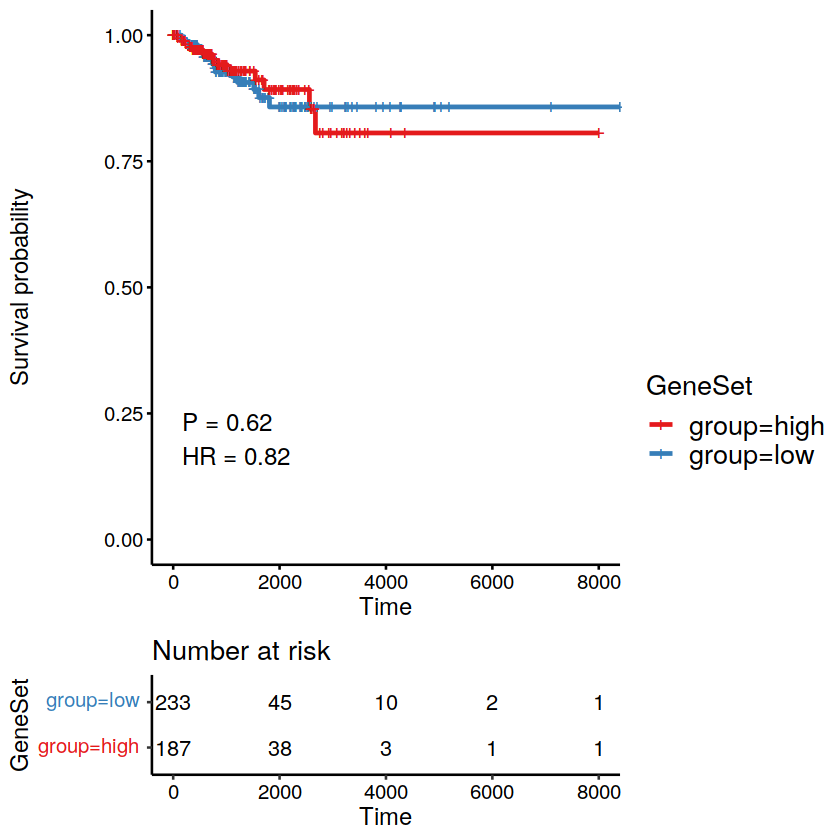

In [77]:
res <- DoSurvivalPlot(cancer = "BRCA", gene.list = genelist, low.quantile = 0.25, high.quantile = 0.80, column.used = c("gender", "stage", 'age'), 
                    survival.used = "DFI", signature.name = "GeneSet")
res$survplot

[1] "Here"
The number of samples used in LIHC is 135 
The number of samples used in LIHC is (high): 60 
The number of samples used in LIHC is (low): 75 


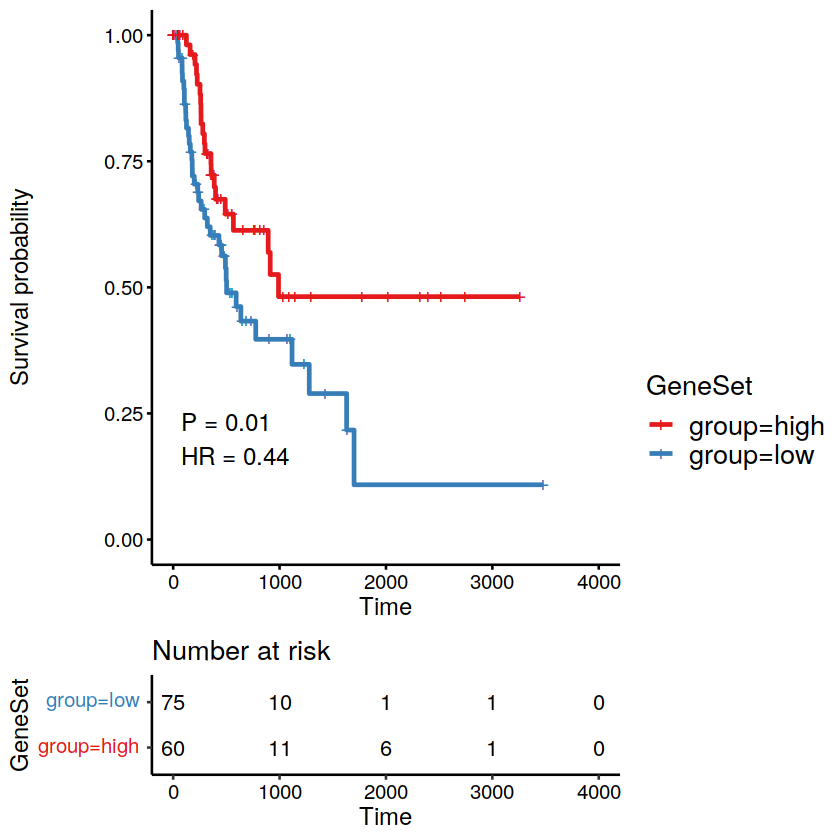

In [76]:
res <- DoSurvivalPlot(cancer = "LIHC", gene.list = genelist, low.quantile = 0.25, high.quantile = 0.80, column.used = c("gender", "stage", 'age'), 
                    survival.used = "DFI", signature.name = "GeneSet")
res$survplot

[1] "Here"
The number of samples used in LIHC is 135 
The number of samples used in LIHC is (high): 60 
The number of samples used in LIHC is (low): 75 


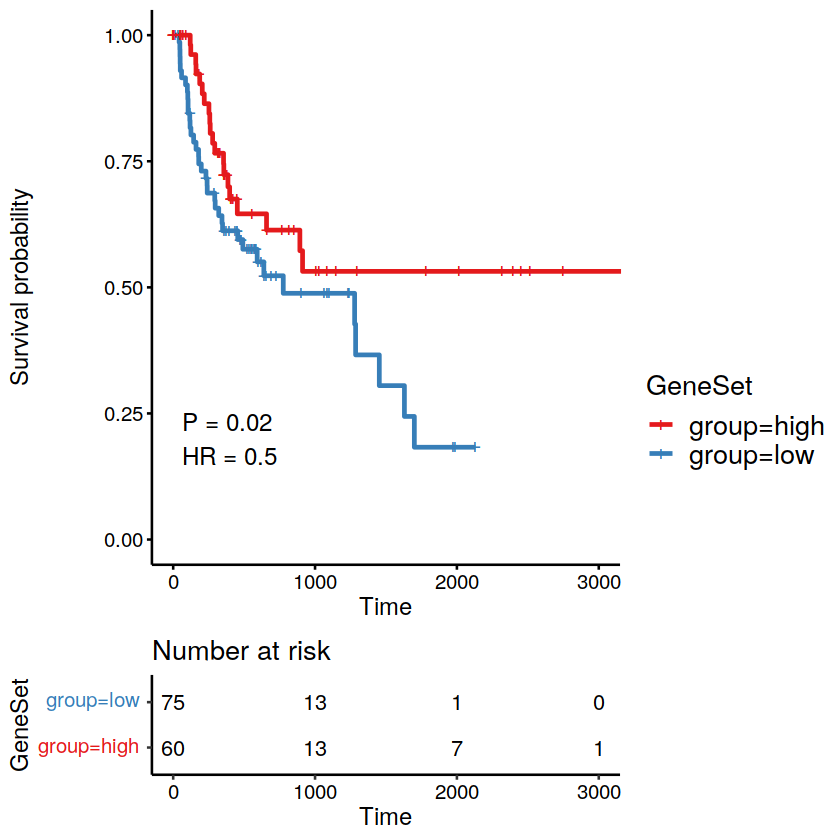

In [63]:
res <- DoSurvivalPlot(cancer = "LIHC", gene.list = genelist, low.quantile = 0.25, high.quantile = 0.80, column.used = c("gender", "stage", 'age'), 
                    survival.used = "DFI", signature.name = "GeneSet")
res$survplot

In [44]:
res <- DoSurvivalPlot(cancer = "LIHC", gene.list = genelist, low.quantile = 0.25, high.quantile = 0.80, column.used = c("gender", "stage", 'age'), 
                    survival.used = "DFI", signature.name = "GeneSet")
ggsave(res$survplot$plot, filename = "../figures/Figure2/S2F_Survival_CAF_FAP.pdf")

[1] "Here"
The number of samples used in LIHC is 135 
The number of samples used in LIHC is (high): 60 
The number of samples used in LIHC is (low): 75 


Saving 6.67 x 6.67 in image



ERROR: Error in UseMethod("grid.draw"): no applicable method for 'grid.draw' applied to an object of class "c('ggsurvplot', 'ggsurv', 'list')"


In [45]:
ggsave(res$survplot$plot, filename = "../figures/Figure2/S2F_Survival_CAF_FAP.pdf")

Saving 6.67 x 6.67 in image



In [36]:
summary(colMeans(res$expr_matrix))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.43090 -0.28525 -0.17482  0.00000  0.06402  3.76242 

# CAF CD36+

In [65]:
markers_caf <- markers[["CAF_C02-CD36"]]
markers_caf <- as.data.frame(markers_caf) %>% rownames_to_column("gene")
topMarkers <- markers_caf %>% 
    filter_at(vars(starts_with("logFC")), all_vars(. > 1)) %>% filter(FDR < 0.01)

[1] "Here"
The number of samples used in LIHC is 135 
The number of samples used in LIHC is (high): 60 
The number of samples used in LIHC is (low): 75 


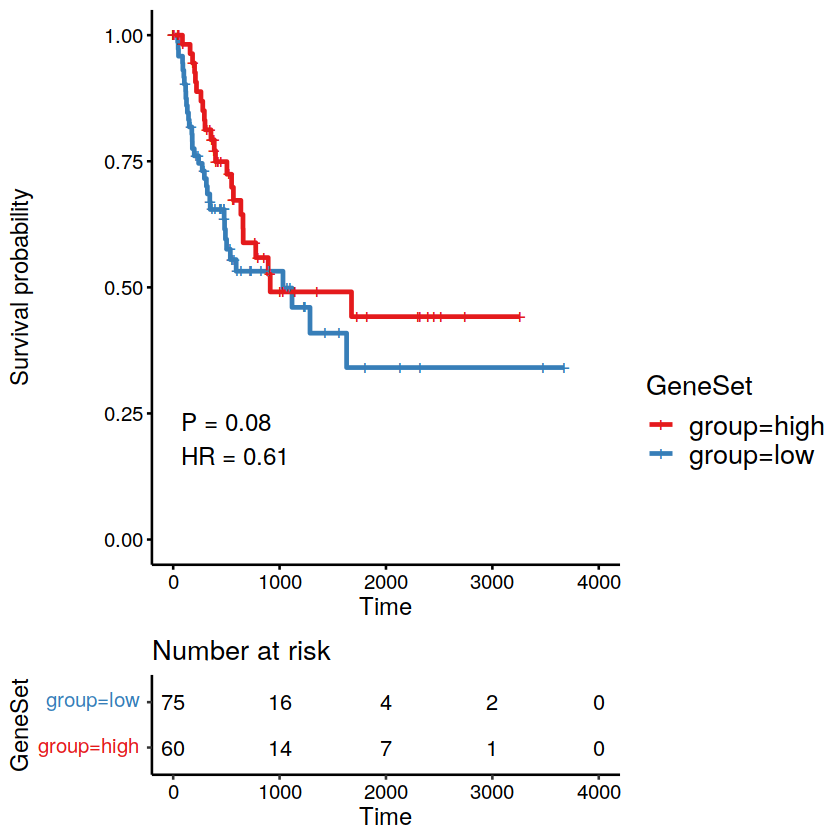

In [67]:
res <- DoSurvivalPlot(cancer = "LIHC", gene.list = topMarkers$gene, low.quantile = 0.25, high.quantile = 0.80, column.used = c("gender", "stage", 'age'), 
                    survival.used = "DFI", signature.name = "GeneSet")
res$survplot

In [64]:
topMarkers %>% filter(gene == 'CCL21')

gene,Top,p.value,FDR,summary.logFC,logFC.B_C01.MS4A1,logFC.B_C02.CD79A,logFC.CAF_C02.CD36,logFC.CD4_C06.IL7R,logFC.CD4_C07.FOXP3,⋯,logFC.Mac_C02.C1QA,logFC.Mast,logFC.Mono_C01.CD14,logFC.Mono_C02.FCGR3A,logFC.NK_C01.FCGR3A,logFC.NK_C02.CD160,logFC.NK_C03.IFNG,logFC.NK_C04.SELL,logFC.NK_C05.MKI67,logFC.VSMC_C03.MYH11
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CCL21,233,6.095638e-12,2.257973e-11,4.968388,4.96719,4.951914,3.820749,4.968388,4.968388,⋯,4.961167,4.968388,4.968388,4.968388,4.968388,4.968388,4.968388,4.968388,4.968388,4.22533
